# Visualization
Given our failures with the integration with kafka, we decided to play safe and save the stream to file.

Obviously this is not realtime, but we decided to follow a contingency plan and at least deliver some visualizations

## Generate the file
spark streaming creates a folder for each RDD created in the discretized stream, and a file for each partition of the rdd. To concatenate them togheter and do some claenup issue this command in the `data` folder:

`
echo "precision,recall,tp,fn,fp,tn" > results.csv && cat results_final/*/part-* | sed  's/(//g; s/)//g' >> results.csv
`



In [7]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
df = pd.read_csv("../data/results.csv",)

In [15]:
df.head()

,precision,recall,tp,fn,fp,tn
0,0.0,0.0,0,0,0,1
1,0.0,0.0,0,0,0,2
2,0.0,0.0,0,0,0,3
3,0.0,0.0,0,0,0,4
4,0.0,0.0,0,0,0,5


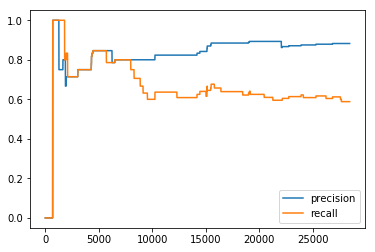

In [14]:
df.plot(use_index=True, y=['precision','recall'])

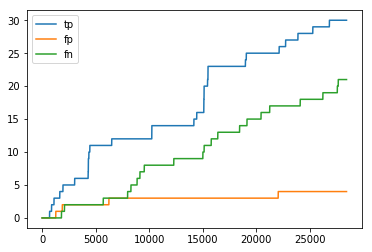

In [19]:
df.plot(use_index=True,y=['tp','fp','fn'])